# (Generalised) Empirical Interpolation Method - (G)EIM

This notebook presents the basic applications of the (Generalised) Empirical Interpolation Method ((G)EIM) for the dimensionality reduction and sensor placement in fluid dynamics problems. The (G)EIM is a powerful technique that allows to approximate complex functions using a reduced number of basis functions and interpolation points, making it suitable for real-time simulations and monitoring applications.

In this tutorial, you will learn:

- How to build `FunctionsList` objects from spatio-temporal matrices of data.
- How to use the EIM and GEIM classes in *pyforce* to perform dimensionality reduction and sensor placement.
- How to reconstruct the field from sparse measurements using the EIM and GEIM methods.

The data for this tutorial comes from a [ROM4FOAM](https://github.com/ERMETE-Lab/ROSE-ROM4FOAM) tutorial, the Buoyant Cavity (see [Introini et al. (2023)](https://doi.org/10.1016/j.anucene.2022.109538)). It is a steady-state simulation of a square cavity with a hot left wall and a cold right wall, leading to natural convection inside the cavity. The simulation is performed using OpenFOAM 2412: the results have been stored in an `npz` file.

## Import OpenFOAM cases from npz files

The data are parametric with respect to the Reynolds and Richardson number (Re and Ri, respectively). The snapshots of velocity, pressure and temperature are stored in an `npz` file, which can be easily loaded using the `numpy` library. Each variable is stored as a 2D array, where each column represents a snapshot at a given parameter value, and each row represents a spatial point in the domain.

`FunctionsList` objects can be built directly from these matrices, specifying the spatial coordinates of the points in the domain.

Among the available variables, we will focus on the temperature field, which is generally easier to measure.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

_data = np.load('Datasets/BuoyantCavity_OF2412/buoyant_cavity.npz', allow_pickle=True)

parameters = _data['parameters']

field = 'T'

from pyforce.tools.functions_list import FunctionsList
dataset = FunctionsList(snap_matrix = _data[field] - 300)

Let us also extract the grid needed by *pyforce* using the `mesh` method, to make a plot of the snapshots

In [2]:
import pyvista as pv
grid = pv.read('Datasets/BuoyantCavity_OF2412/mesh_cavity.vtk')
grid

UnstructuredGrid,Information
N Cells,16384
N Points,33282
X Bounds,"0.000e+00, 1.000e+00"
Y Bounds,"0.000e+00, 1.000e+00"
Z Bounds,"0.000e+00, 1.000e-01"
N Arrays,0


Let us make a plot of the snapshots

In [3]:
# dataset.plot_sequence(grid, sampling = 2, title=field+' id = ', title_size=15, resolution=[700,600], cmap='jet', varname=field)

Before delving into the different techniques, let us split the data into train and test.

In [4]:
from pyforce.tools.functions_list import train_test_split

train_params, test_params, train_dataset, test_dataset = train_test_split(parameters, dataset, test_size=0.2, random_state=42)

## Offline Phase
As already mentioned in the previous tutorial, ROM methods are typically divided into an offline and an online phase. The offline phase is the most computationally expensive, as it involves the construction of the reduced basis and the selection of the interpolation points. However, this phase is performed only once, and the results can be reused for multiple online simulations.

The (G)EIM techniques are based on a greedy algorithm that iteratively selects the most informative basis functions and interpolation points/sensors: this latter information is very interesting, as it can be used to place sensors in the most informative locations of the domain to ensure an optimal state reconstruction.

We will focus on both the EIM and GEIM methods: the main difference lies in the fact that the former considers pointwise measurements, while the latter can handle more general linear functionals, such as averages over a small region or directional derivatives.

### EIM
This method allows to select interpolation points and build a reduced basis using pointwise measurements of the field. Even though it was originally developed for hyper-reduction in the context of reduced order models, it can be effectively used for sensor placement and field reconstruction.

The initialization of the class requires the grid and the variable name, while the `fit` method takes as input a `FunctionsList` object containing the snapshots used for the offline phase. The maximum number of basis functions/interpolation points can be specified using the `Mmax` parameter.

In [5]:
from pyforce.offline.eim import EIM as OfflineEIM

eim_offline = OfflineEIM(grid, varname=field)
max_abs_err, beta_coeffs = eim_offline.fit(train_dataset, Mmax = 50, 
                                           verbose=True # optional
                                           )

  Iteration 050 | Abs Err (Linfty): 2.96e-03 - EIM done


The error of the interpolation procedure of the EIM is connected to the Lebesgue constant, which is a measure of the stability and accuracy of the interpolation. The class provides a method to compute the Lebesgue constant, which can be useful to assess the quality of the interpolation: the higher the Lebesgue constant, the more unstable the interpolation.

In [6]:
lebesgue_eim = eim_offline.compute_lebesgue_constant()

Let us make a plot of the error decay, the Lebesgue constant and the magic points during the greedy procedure.

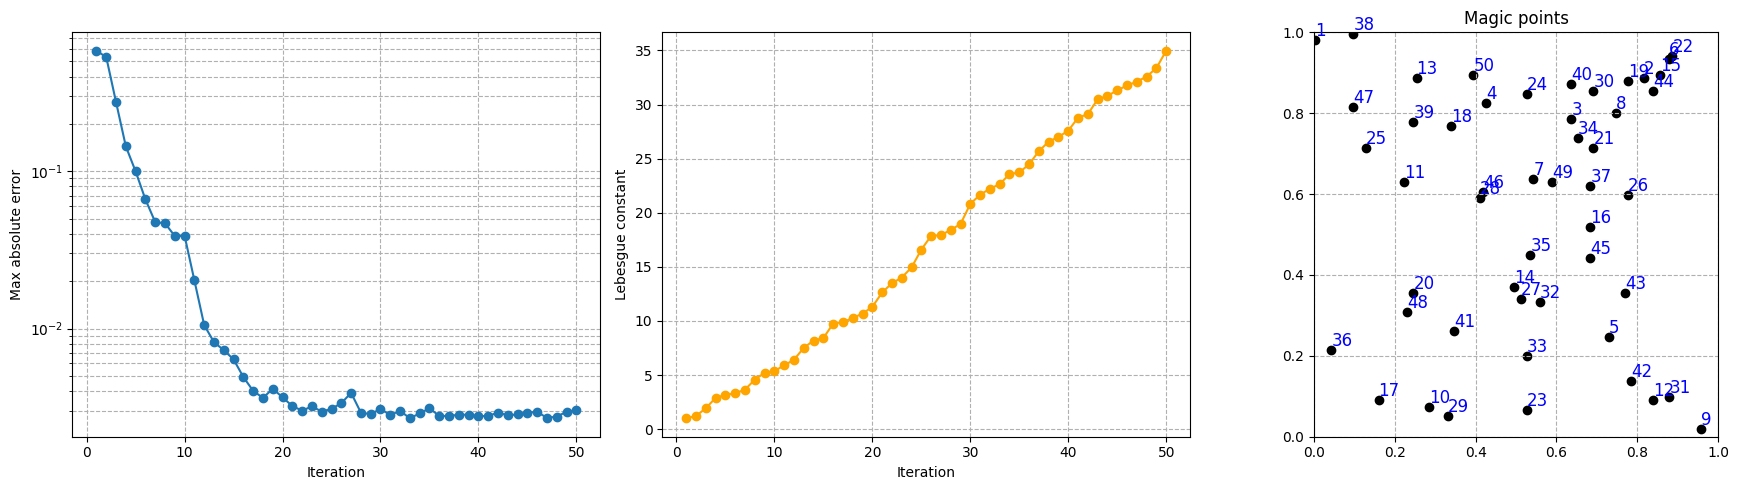

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(6 * 3, 5))

Mplot = np.arange(1, len(max_abs_err) + 1)

axs[0].semilogy(Mplot, max_abs_err, marker='o')
axs[0].set_xlabel('Iteration')
axs[0].grid(True, which="both", ls="--")
axs[0].set_ylabel('Max absolute error')

axs[1].plot(Mplot, lebesgue_eim, marker='o', color='orange')  
axs[1].set_ylabel('Lebesgue constant')
axs[1].set_xlabel('Iteration')
axs[1].grid(True, which="both", ls="--")

_magic_points = np.array(eim_offline.magic_points['points'])[:, :2]

axs[2].scatter(_magic_points[:, 0], _magic_points[:, 1], marker='o', color = 'black')
for i, (x, y) in enumerate(_magic_points):
    axs[2].text(x, y, str(i+1), fontsize=12, ha='left', va='bottom', color='blue')
axs[2].set_title('Magic points')
axs[2].set_aspect('equal', 'box')
axs[2].grid(True, which="both", ls="--")
axs[2].set_xlim(grid.bounds[0], grid.bounds[1])
axs[2].set_ylim(grid.bounds[2], grid.bounds[3])

plt.tight_layout()
plt.show()

Let us plot also the first 10 magic functions, using `matplotlib`.

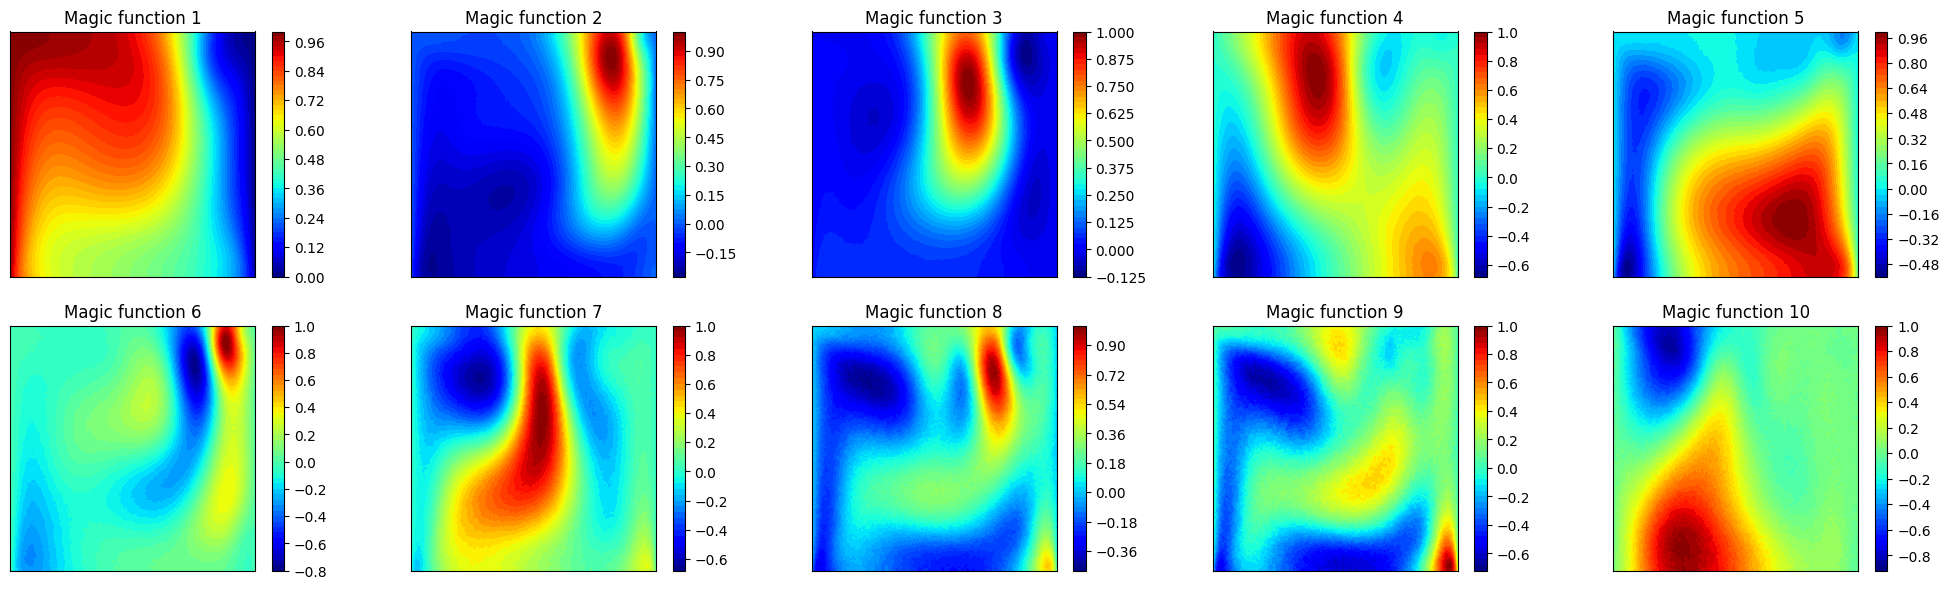

In [8]:
nrows = 2
ncols = 5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3.5 * nrows))
axs = axs.flatten()

nodes = grid.cell_centers().points

for ii in range(len(axs)):
    _mf = eim_offline.magic_functions(ii)

    c = axs[ii].tricontourf(nodes[:, 0], nodes[:, 1], _mf, levels=50, cmap='jet')
    fig.colorbar(c, ax=axs[ii])
    axs[ii].set_title(f'Magic function {ii+1}')

    axs[ii].set_xticks([])
    axs[ii].set_yticks([])
    axs[ii].set_aspect('equal', 'box')

Let us make also a 3D surface plot of the reduced coefficients $\beta_m$.

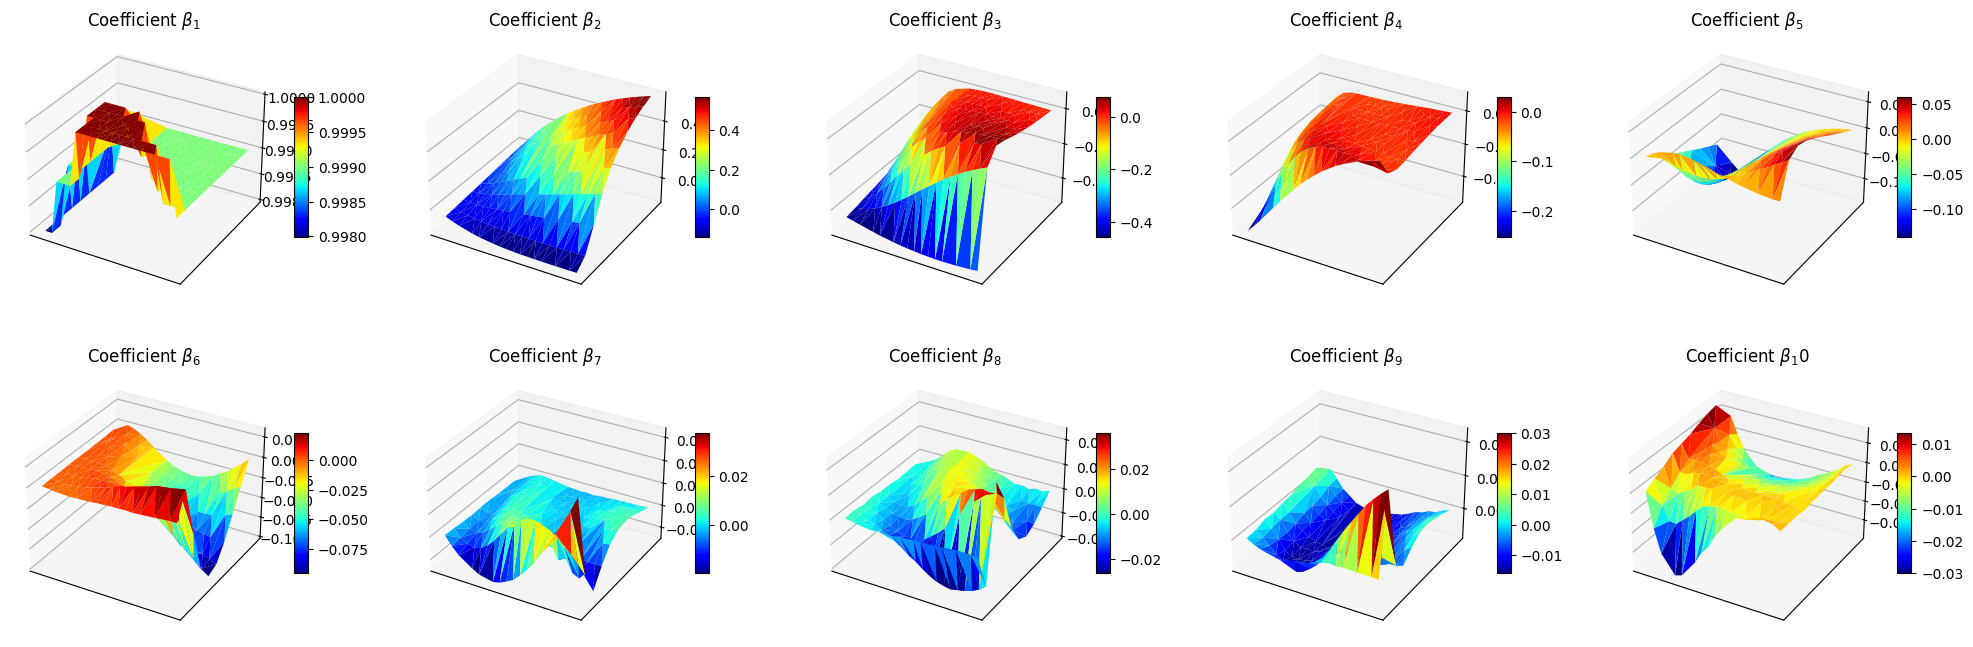

In [9]:
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plots

fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), subplot_kw={'projection': '3d'})
axs = axs.flatten()

for ii in range(len(axs)):
    ax = axs[ii]
    X = train_params[:, 0]
    Y = train_params[:, 1]
    Z = beta_coeffs[ii]

    surf = ax.plot_trisurf(X, Y, Z, cmap='jet', edgecolor='none')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    ax.set_title(f'Coefficient $\\beta_{ii+1}$')
    
    ax.set_xticks([])
    ax.set_yticks([])

Let us also visualise the matrix $B$ of the EIM, which is a lower triangular matrix with ones on the diagonal and all the entries are between -1 and 1.

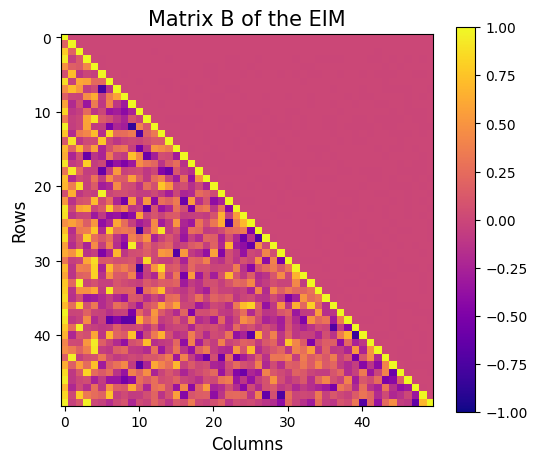

In [10]:
fig = plt.figure(figsize=(6,5))

plt.imshow(eim_offline.matrix_B, cmap='plasma', vmin=-1, vmax=1)
plt.title('Matrix B of the EIM', fontsize=15)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Rows', fontsize=12)
plt.colorbar()

The class also provides a method to store the results of the greedy procedure: the magic functions and the magic sensors. The method `save` can be used to save the results in a specified folder, exploiting the method `store` of `FunctionsList`.

In [11]:
import os
path_res = 'Results/02/OfflineEIM/'
os.makedirs(path_res, exist_ok=True)

eim_offline.save(path_res)

### GEIM
The GEIM method is a generalization of the EIM, which allows to use more general linear functionals as measurements. This is particularly useful in practical applications, where pointwise measurements may not be available or feasible.

The initialization and fitting of the GEIM class is similar to the EIM, with the addition of the `sensors_type` parameter, which specifies the type of linear functionals to be used.
**At the moment, three classes of functionals are implemented:**
- `Gaussian`: Gaussians centered with a given point spread: $$\mathcal{K}(\mathbf{x}) = \exp\left(-\frac{(\mathbf{x}-\mathbf{x}_m)^2}{2s^2}\right)$$
- `Exponential`: Exponentials centered with a given point spread: $$\mathcal{K}(\mathbf{x}) = \exp\left(-\frac{|\mathbf{x}-\mathbf{x}_m|}{s}\right)$$
- `IndicatorFunction`: Indicator functions over a circular region of given radius: $$\mathcal{K}(\mathbf{x}) = \begin{cases} 1 & \text{if } |\mathbf{x}-\mathbf{x}_m|_2 \leq r\\ 0 & \text{otherwise} \end{cases}$$

**Note**: this class works only for scalar fields, at the moment.

The most natural choice are Gaussian kernels, as specified in [Riva et al. (2024)](https://www.sciencedirect.com/science/article/pii/S0307904X24003196).

In [12]:
from pyforce.offline.geim import GEIM

geim_offline = GEIM(grid, varname=field, sensors_type='Gaussian')

The `fit` method takes as input a `FunctionsList` object containing the snapshots used for the offline phase. The maximum number of basis functions/interpolation points can be specified using the `Mmax` parameter. In addition, according to the chosen `sensors_type`, a dictionary of parameters must be provided, containing:
- `s`: the spread of the kernels (for `Gaussian` and `Exponential`)
- `r`: the radius of the circular region (for `IndicatorFunction`)
- `xm_list`: a list of possible centers for the kernels (for all types) - optional, if not provided the centers will be chosen among the grid points

In [13]:
sens_params = {
    's': 0.025, # spread of the Gaussian kernels - hyperparameter to be tuned according to the physical system
    'xm_list': grid.cell_centers().points[::10].tolist() # optional (sampling every 10 points to speed up the process)
}

max_abs_err, max_rel_err, train_beta_geim_coeffs = geim_offline.fit(train_dataset, 
                                                                        Mmax = 50, 
                                                                        sensor_params=sens_params,
                                                                        verbose=True # optional
                                                                    )

Creating Gaussian Sensor Library: 100.000 / 100.00% - 0.000229 s/it


Also in this case, the error of the interpolation procedure of the GEIM is connected to the Lebesgue constant, which is a measure of the stability and accuracy of the interpolation. The class provides a method to compute the Lebesgue constant, which can be useful to assess the quality of the interpolation: the higher the Lebesgue constant, the more unstable the interpolation.

In [14]:
leb = geim_offline.compute_lebesgue_constant(verbose=True)

Computing orthonormal basis: 50.000 / 50.00 - 0.002905 s/it


/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/offline/geim.py:478: RuntimeWarning: divide by zero encountered in matmul
  _eigvals = np.linalg.eigvals(_A.T @ _A)
/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/offline/geim.py:478: RuntimeWarning: overflow encountered in matmul
  _eigvals = np.linalg.eigvals(_A.T @ _A)
/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/offline/geim.py:478: RuntimeWarning: invalid value encountered in matmul
  _eigvals = np.linalg.eigvals(_A.T @ _A)


Computing Lebesgue constant: 50.000 / 50.00 - 0.018374 s/it


Let us make a plot of the error decay and the Lebesgue constant.

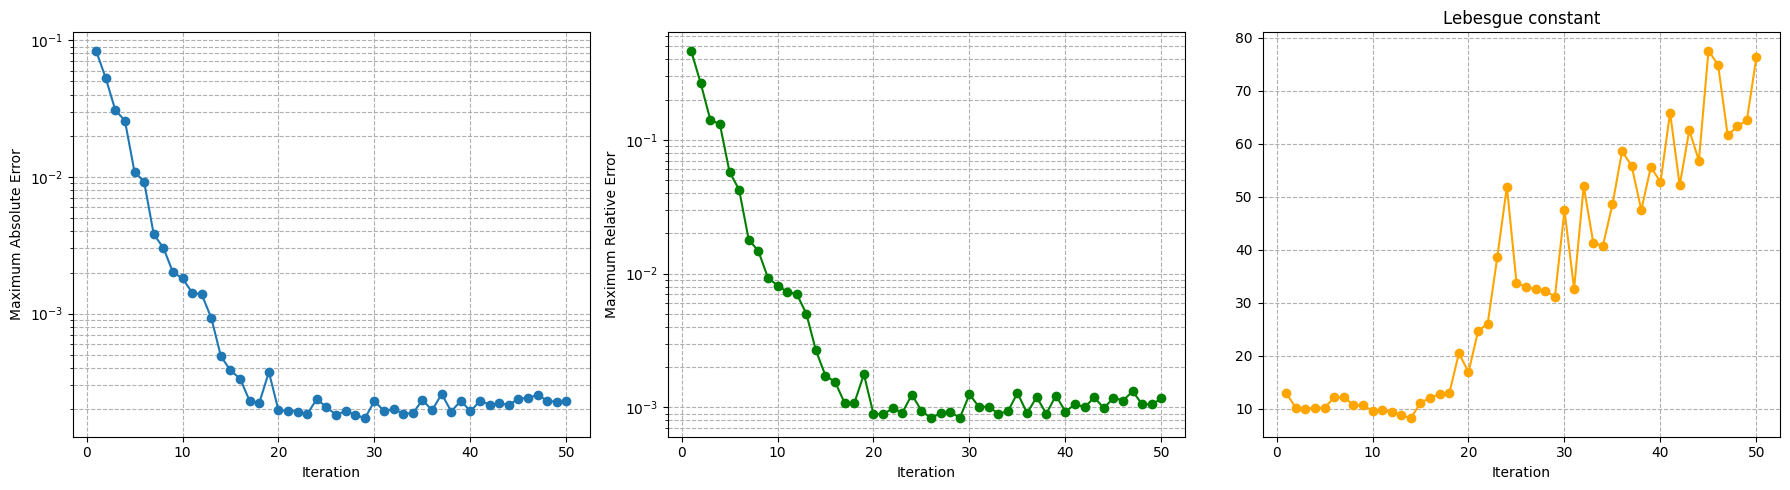

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(6 * 3, 5))

Mplot = np.arange(1, len(max_abs_err) + 1)

axs[0].semilogy(Mplot, max_abs_err, marker='o')
axs[0].set_ylabel('Maximum Absolute Error')
axs[0].set_xlabel('Iteration')
axs[0].grid(True, which="both", ls="--")

axs[1].semilogy(Mplot, max_rel_err, marker='o', color='green')
axs[1].set_ylabel('Maximum Relative Error')
axs[1].set_xlabel('Iteration')
axs[1].grid(True, which="both", ls="--")

axs[2].plot(Mplot, leb, marker='o', color='orange')  
axs[2].set_title('Lebesgue constant')
axs[2].set_xlabel('Iteration')
axs[2].grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

The general form of the linear functionals used as sensors is:
$$v(u) = \int_\Omega \mathcal{K}(\mathbf{x}) u(\mathbf{x}) d\mathbf{x}$$
where $\mathcal{K}(\mathbf{x})$ is the kernel function, which can be a Gaussian, an Exponential or an Indicator function. In this context, there exist the Riesz representation of the functional in the Hilbert space $\mathcal{H}$, which is the function $g(\mathbf{x})$ such that:
$$
v(\psi) = \left(\psi, g\right)_{\mathcal{H}} \qquad \forall \psi \in \mathcal{H}
$$
At the moment, the Hilbert space is assumed to be $L^2$, so that the Riesz representation is simply the kernel function itself. In this way, it is possible to visualize the sensors in terms of their Riesz representation.

The class provides a method to plot the Riesz representation of the first `M` sensors, cumulated:
$$
G(\mathbf{x}) = \sum_{m=1}^M \frac{g_m(\mathbf{x})}{\max |g_m|}
$$

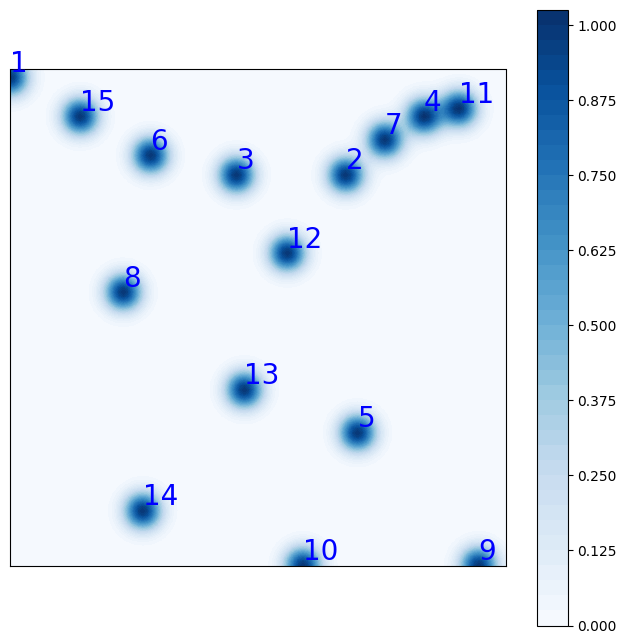

In [16]:
fig = geim_offline.plot_sensors(M=15, levels=40, fontsize_sens=20, fig_length=8,
                                color_sens='blue', cmap='Blues')

ax = fig.get_axes()[0]
ax.set_aspect('equal')

Let us plot also the first 10 magic functions, using `matplotlib`.

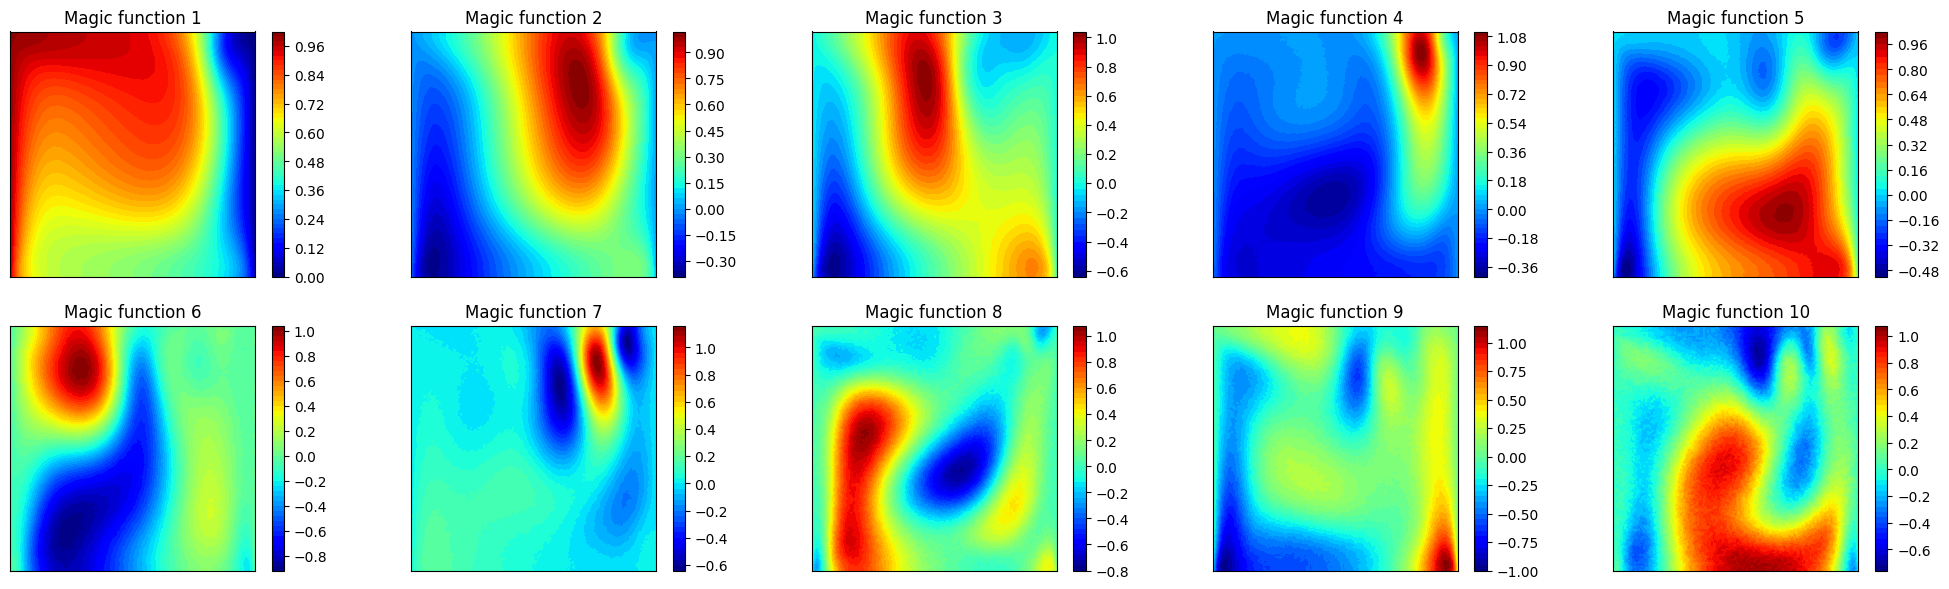

In [17]:
nrows = 2
ncols = 5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3.5 * nrows))
axs = axs.flatten()

nodes = grid.cell_centers().points

for ii in range(len(axs)):
    _mf = geim_offline.magic_functions(ii)

    c = axs[ii].tricontourf(nodes[:, 0], nodes[:, 1], _mf, levels=50, cmap='jet')
    fig.colorbar(c, ax=axs[ii])
    axs[ii].set_title(f'Magic function {ii+1}')

    axs[ii].set_xticks([])
    axs[ii].set_yticks([])
    axs[ii].set_aspect('equal', 'box')

Let us make a plot of the reduced coefficients $\beta_m$.

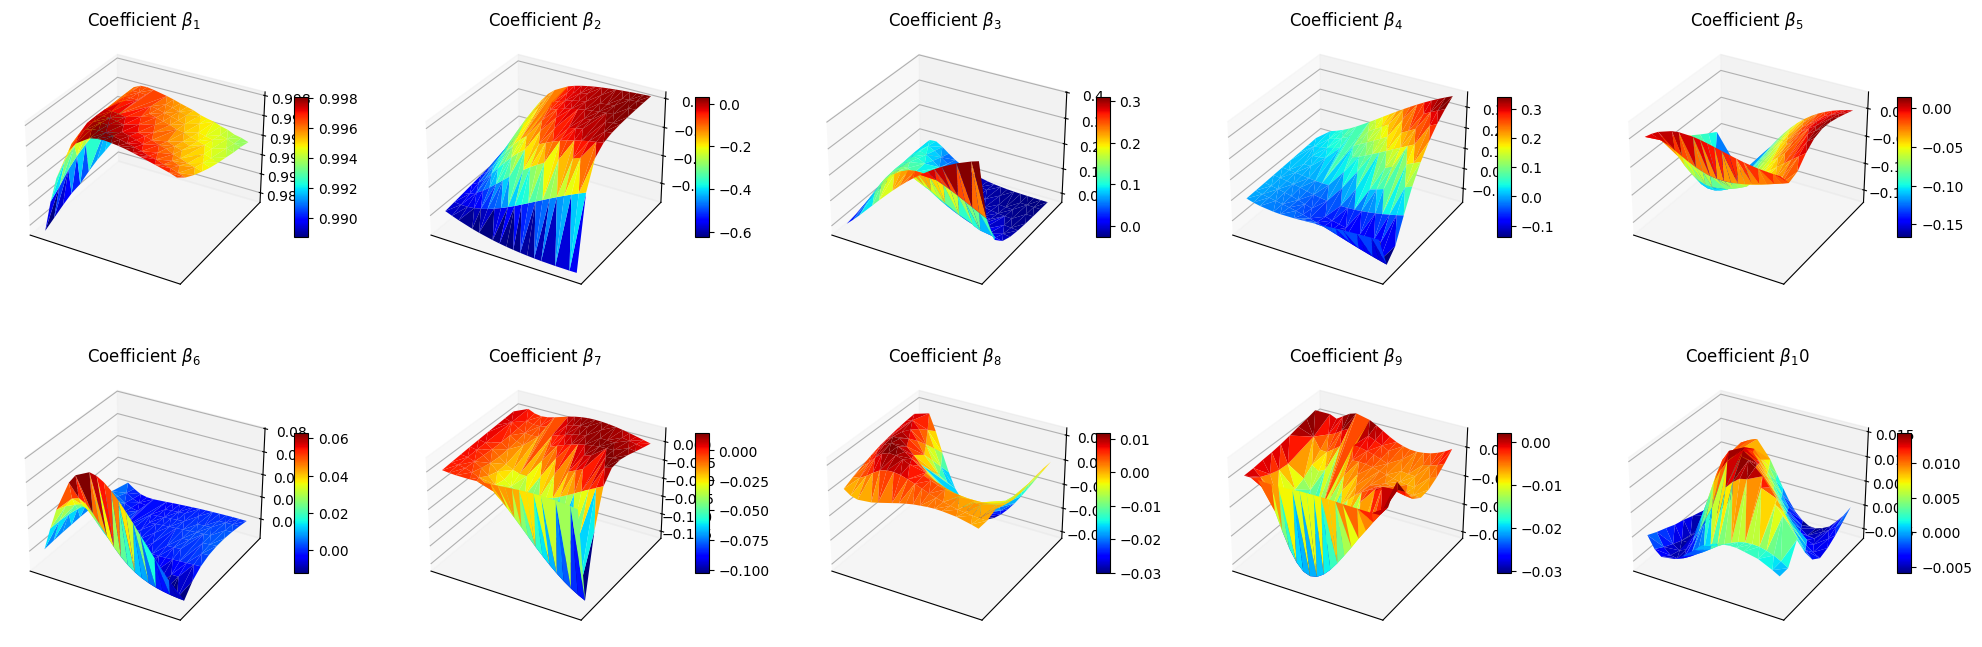

In [18]:
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plots

fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), subplot_kw={'projection': '3d'})
axs = axs.flatten()

for ii in range(len(axs)):
    ax = axs[ii]
    X = train_params[:, 0]
    Y = train_params[:, 1]
    Z = train_beta_geim_coeffs[ii]

    surf = ax.plot_trisurf(X, Y, Z, cmap='jet', edgecolor='none')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    ax.set_title(f'Coefficient $\\beta_{ii+1}$')
    
    ax.set_xticks([])
    ax.set_yticks([])

Let us also visualise the matrix $B$ of the GEIM, which is a lower triangular matrix with ones on the diagonal and all the entries are between -1 and 1.fig = plt.figure(figsize=(6,5))

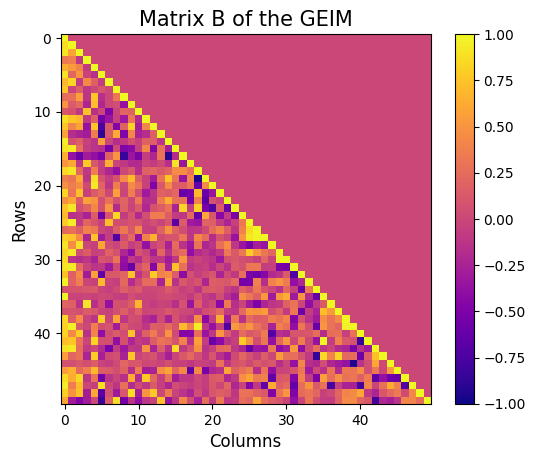

In [19]:
plt.imshow(geim_offline.matrix_B, cmap='plasma', vmin=-1, vmax=1)
plt.title('Matrix B of the GEIM', fontsize=15)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Rows', fontsize=12)
plt.colorbar()

It is then possible to store the results of the greedy procedure: the magic functions and the magic sensors. The method `save` can be used to save the results in a specified folder, exploiting the method `store` of `FunctionsList`.

In [20]:
import os
path_res = 'Results/02/OfflineGEIM/'
os.makedirs(path_res, exist_ok=True)

geim_offline.save(path_res)

## Online Phase
The online phase is the most computationally efficient, as it involves only the calculation of the reduced coefficients and the reconstruction of the high-dimensional field from sparse measurements. This phase can be performed in real-time, making it suitable for monitoring applications.

In this section, we will show how to use the EIM and GEIM classes to perform the online phase, using the results of the offline phase: in particular, the reconstruction capabilities, the influence of noise in the measurements and the effect of regularization techniques.

### EIM

Estimation with EIM can be done by solving the linear system for the reduced coefficients $\{\beta_m\}_{m=1}^M$:
$$
\mathbf{B}\boldsymbol{\beta} = \mathbf{y}
$$
in which the measurement vector $\mathbf{y}$ is given by the pointwise measurements of the field at the interpolation points, i.e. $y_m = u(x_m)$.

The class `EIM` within the `online` module can be used: the initialization requires the grid and optionally the variable name.

In [21]:
from pyforce.online.eim import EIM as OnlineEIM

eim_online = OnlineEIM(grid, varname=field)

The class needs the user to provide the magic functions through the `set_basis` method, which can be either loaded directly or read from a folder where they have been stored. Similarly, the interpolation points can be provided using the `set_magic_points` method.

In [22]:
# eim_online.set_basis(path_folder='Results/02/OfflineEIM/')
eim_online.set_basis(basis = eim_offline.magic_functions)

# eim_online.set_magic_points(path_folder='Results/02/OfflineEIM/')
eim_online.set_magic_points(magic_points = eim_offline.magic_points)

Once these information have been provided, the matrix $B$ can be computed using the `compute_B_matrix` method.

In [23]:
eim_online.compute_B_matrix()

Let us observe how the reconstruction error decays with the number of sensors, using the test set.

Computing errors - T: 50.000 / 50.00 - 0.007324 s/it


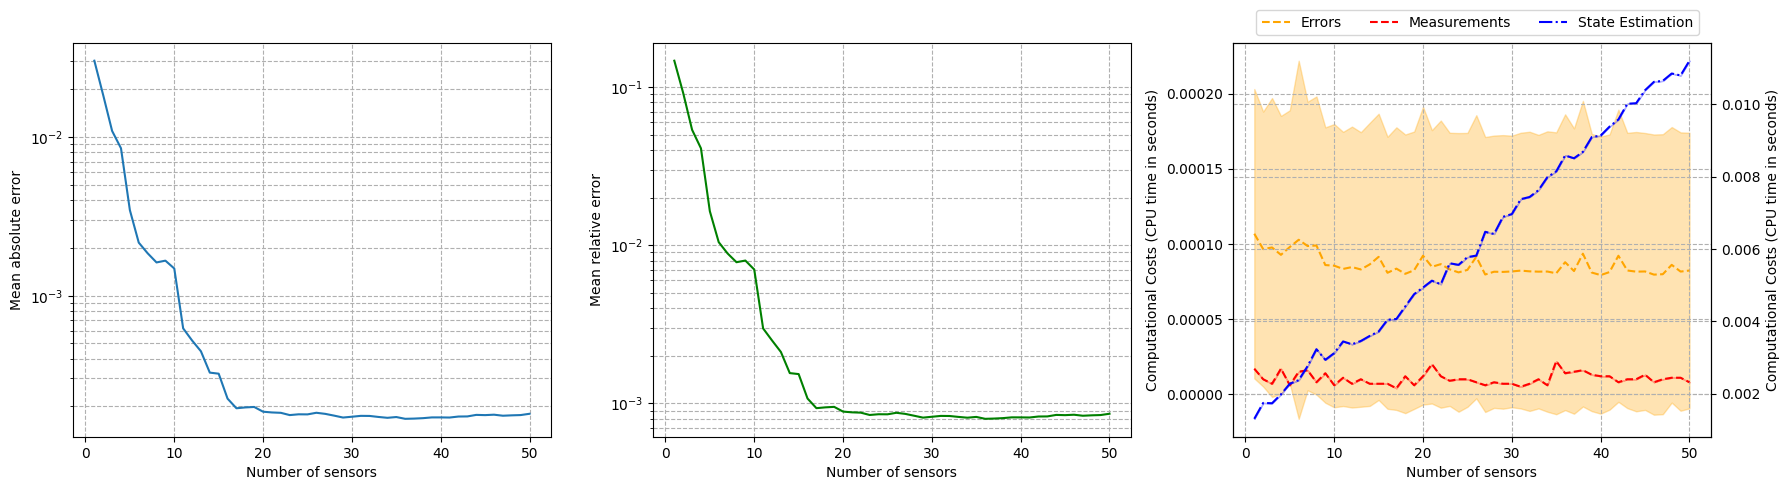

In [24]:
np.random.seed(42)
res_eim_online_noiseless = eim_online.compute_errors(test_dataset, Mmax=50, verbose=True)

Mplot = np.arange(1, len(res_eim_online_noiseless[0]) + 1)

fig, axs = plt.subplots(1, 3, figsize=(6 * 3, 5))

axs[0].semilogy(Mplot, res_eim_online_noiseless[0])
axs[1].semilogy(Mplot, res_eim_online_noiseless[1], color='green')

axs[2].plot(Mplot, res_eim_online_noiseless[2]['Errors'].mean(axis=0), color='orange', linestyle='--', label='Errors')
axs[2].fill_between(Mplot, res_eim_online_noiseless[2]['Errors'].mean(axis=0) - res_eim_online_noiseless[2]['Errors'].std(axis=0),
                    res_eim_online_noiseless[2]['Errors'].mean(axis=0) + res_eim_online_noiseless[2]['Errors'].std(axis=0), color='orange', alpha=0.3)

axs[2].plot(Mplot, res_eim_online_noiseless[2]['Measures'].mean(axis=0), color='red', linestyle='--', label='Measurements')
axs[2].fill_between(Mplot, res_eim_online_noiseless[2]['Measures'].mean(axis=0) - res_eim_online_noiseless[2]['Measures'].std(axis=0),
                 res_eim_online_noiseless[2]['Measures'].mean(axis=0) + res_eim_online_noiseless[2]['Measures'].std(axis=0), color='red', alpha=0.3)

_ax = axs[2].twinx()
_ax.plot(Mplot, res_eim_online_noiseless[2]['StateEstimation'].mean(axis=0), color='blue', linestyle='-.', label='State Estimation')
_ax.fill_between(Mplot, res_eim_online_noiseless[2]['StateEstimation'].mean(axis=0) - res_eim_online_noiseless[2]['StateEstimation'].std(axis=0),
                 res_eim_online_noiseless[2]['StateEstimation'].mean(axis=0) + res_eim_online_noiseless[2]['StateEstimation'].std(axis=0), color='blue', alpha=0.3)

_line, _label = axs[2].get_legend_handles_labels()
_tmp = _ax.get_legend_handles_labels()
_line += _tmp[0]
_label += _tmp[1]
axs[2].legend(_line, _label, loc=(0.05, 1.02), ncol=3)

for ax in axs:
    ax.set_xlabel('Number of sensors')
    ax.grid(True, which="both", ls="--")
_ax.grid(True, which="both", ls="--")

axs[0].set_ylabel('Mean absolute error')
axs[1].set_ylabel('Mean relative error')
axs[2].set_ylabel('Computational Costs (CPU time in seconds)')
_ax.set_ylabel('Computational Costs (CPU time in seconds)')

plt.tight_layout()

For real-world applications, the measurements are often corrupted by noise $y_m = u(x_m) + \epsilon_m$, where $\epsilon_m$ is a random noise term. The class provides the possibility to add Gaussian noise to the measurements when estimating the fields: we will observe how the relative reconstruction error is affected by different levels of noise.

Computing errors with noise level: 0.0
Computing errors with noise level: 0.001
Computing errors with noise level: 0.01
Computing errors with noise level: 0.025
Computing errors with noise level: 0.05


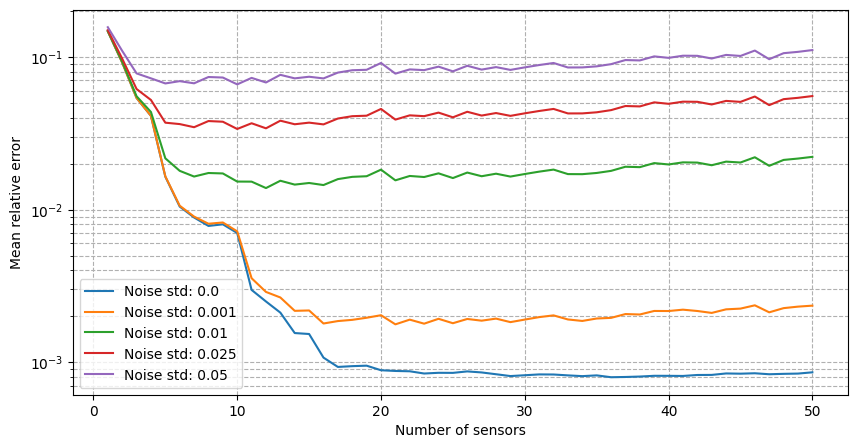

In [25]:
errors_eim_online_sensitivity_noise = {}
noise_values = [0., 0.001, 0.01, 0.025, 0.05]

for noise in noise_values:

    print(f'Computing errors with noise level: {noise}')

    np.random.seed(42)
    res_eim_online = eim_online.compute_errors(test_dataset, Mmax=50, noise_std=noise, verbose=False)
    errors_eim_online_sensitivity_noise[noise] = res_eim_online[1]

fig, axs = plt.subplots(figsize=(10,5))

for noise in noise_values:
    axs.semilogy(Mplot, errors_eim_online_sensitivity_noise[noise], label=f'Noise std: {noise}')

axs.set_xlabel('Number of sensors')
axs.set_ylabel('Mean relative error')
axs.grid(True, which="both", ls="--")
axs.legend()

It can be observed that there is a strong degradation of the performance and instability of the reconstruction process is observed. Following the work of [Introini et al. (2023)](https://www.sciencedirect.com/science/article/pii/S0045782522007290), a possible solution is to use Tikhonov regularization to stabilize the solution of the linear system as follows
$$
\mathbb{B}^T\mathbb{B}\boldsymbol{\beta} + \lambda \mathbb{T}\boldsymbol{\beta} = \mathbb{B}^T\mathbf{y} + \lambda \mathbb{B}^T \langle \boldsymbol{\beta} \rangle
$$
where $\mathbb{T}$ is a regularization matrix (related to the standard deviation of $\boldsymbol{\beta}$ from the training set), $\lambda$ is the regularization parameter and $\langle \boldsymbol{\beta} \rangle$ is the mean of the reduced coefficients over the training set. 

For uncostrained problems, the regularisation parameters $\lambda$ has an optimal value at $\sigma^2$, where $\sigma^2$ is the variance of the noise. The matrix $\mathbb{T}$ and the mean of the coefficients can be computed using the `set_tikhonov_matrices` method, which requires as input either the training coefficients or the training snapshots (in this case, the training coefficients will be computed internally).

The `compute_errors` method of the class allows to specify the type of regularization and the corresponding parameters through the `regularization_params` dictionary: required entries are the `type` (currently only `tikhonov` is implemented) and the `lambda` parameter.

Computing errors with noise level with regularisation: 0.0


/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/online/eim.py:287: RuntimeWarning: divide by zero encountered in matmul
  rhs = _B.T @ measures[:_m] + lambda_reg * (_T.T @ _T @ _beta_mean[:, np.newaxis])
/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/online/eim.py:287: RuntimeWarning: overflow encountered in matmul
  rhs = _B.T @ measures[:_m] + lambda_reg * (_T.T @ _T @ _beta_mean[:, np.newaxis])
/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/online/eim.py:287: RuntimeWarning: invalid value encountered in matmul
  rhs = _B.T @ measures[:_m] + lambda_reg * (_T.T @ _T @ _beta_mean[:, np.newaxis])
/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/online/eim.py:286: RuntimeWarning: divide by zero encountered in matmul
  A = _B.T @ _B + lambda_reg * (_T.T @ _T)
/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/online/eim.py:286: RuntimeWarning:

Computing errors with noise level with regularisation: 0.001
Computing errors with noise level with regularisation: 0.01
Computing errors with noise level with regularisation: 0.025
Computing errors with noise level with regularisation: 0.05


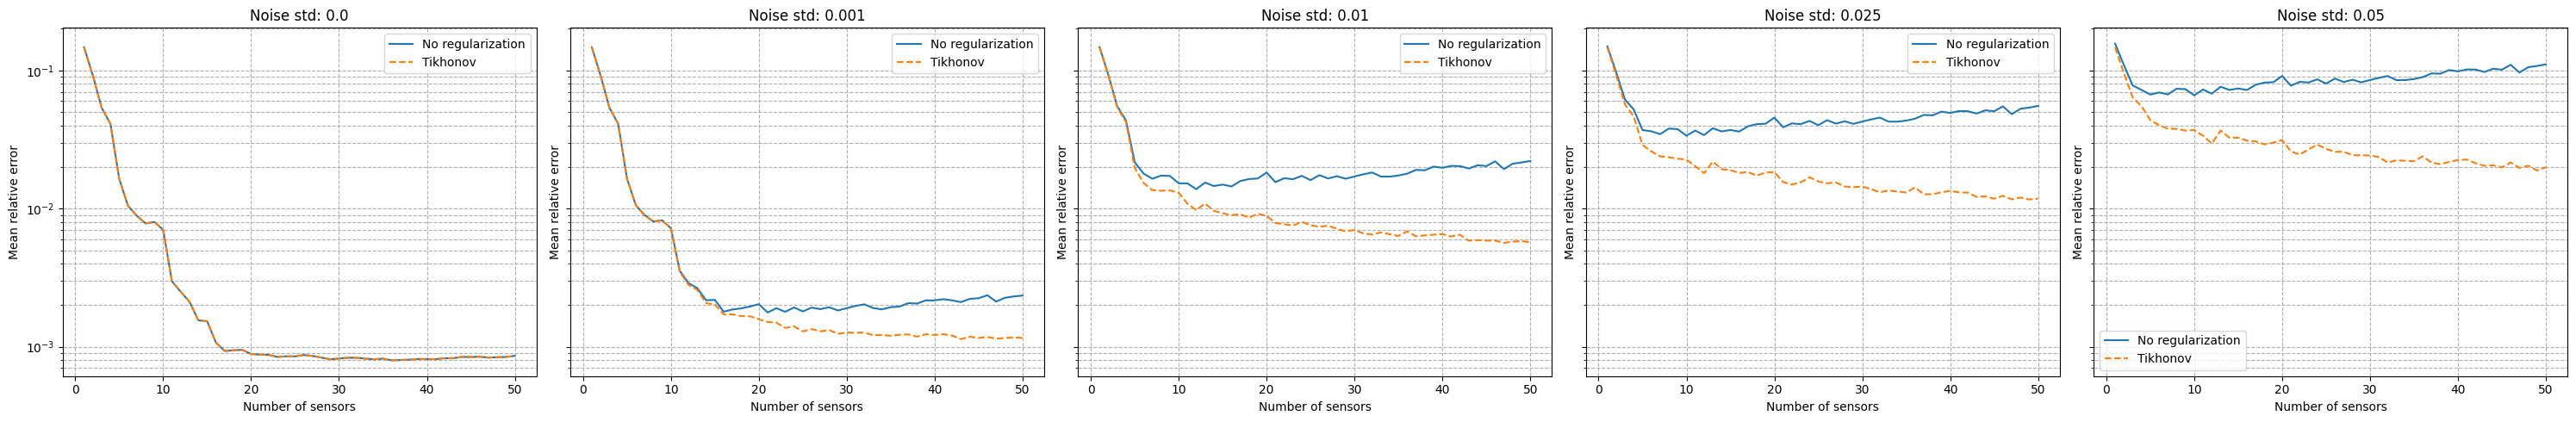

In [26]:
# eim_online.set_tikhonov_matrices(train_beta_geim_coeffs)
eim_online.set_tikhonov_matrices(train_snaps=train_dataset)

errors_eim_online_sensitivity_tikhonov = {}
noise_values = [0., 0.001, 0.01, 0.025, 0.05]

for noise in noise_values:

    print(f'Computing errors with noise level with regularisation: {noise}')

    np.random.seed(42)
    res_eim_online = eim_online.compute_errors(test_dataset, Mmax=50, noise_std=noise, verbose=False, regularization_params={'type': 'tikhonov', 'lambda': noise**2})
    errors_eim_online_sensitivity_tikhonov[noise] = res_eim_online[1]

fig, axs = plt.subplots(1, len(noise_values), figsize=(6* len(noise_values), 5), sharey=True, sharex=True)

for i, noise in enumerate(noise_values):
    axs[i].semilogy(Mplot, errors_eim_online_sensitivity_noise[noise], label=f'No regularization')
    axs[i].semilogy(Mplot, errors_eim_online_sensitivity_tikhonov[noise], linestyle='--', label=f'Tikhonov')
    axs[i].set_title(f'Noise std: {noise}')

for ax in axs.flatten():
    ax.set_xlabel('Number of sensors')
    ax.set_ylabel('Mean relative error')
    ax.grid(True, which="both", ls="--")
    ax.legend()

plt.tight_layout()

Let us observe how the estimation is affected by the use of Tikhonov regularization.

Text(0.5, 1.0, 'Residual with Tikhonov regularization')

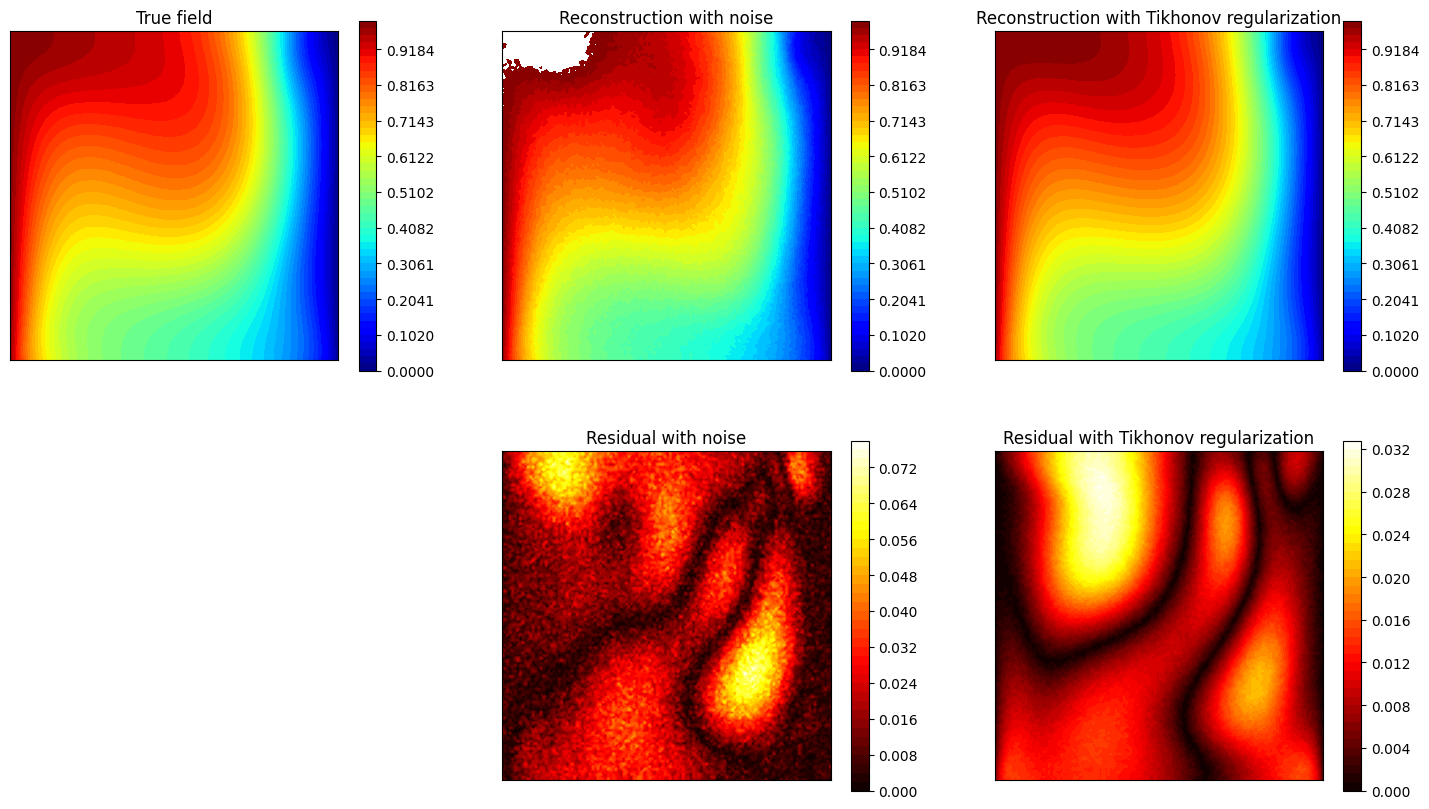

In [27]:
noise_test = 0.02
M_test = 20

measures = eim_online.get_measurements(test_dataset, noise_std=noise_test, M=M_test)
recons_noise = eim_online.estimate(measures, M = M_test)
recons_tikhonov = eim_online.estimate(measures, M = M_test, regularization_params={'type': 'tikhonov', 'lambda': noise_test**2})

nodes = grid.cell_centers().points
levels = np.linspace(0, 1, 50)

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

c = axs[0,0].tricontourf(nodes[:, 0], nodes[:, 1], test_dataset(-1), levels=levels, cmap='jet')
axs[0,1].tricontourf(nodes[:, 0], nodes[:, 1], recons_noise(-1), levels=levels, cmap='jet')
axs[0,2].tricontourf(nodes[:, 0], nodes[:, 1], recons_tikhonov(-1), levels=levels, cmap='jet')

for ax in axs[0,:]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')
    fig.colorbar(c, ax=ax)
    
axs[1,0].axis('off')
c = axs[1,1].tricontourf(nodes[:, 0], nodes[:, 1], np.abs(test_dataset(-1) - recons_noise(-1)), levels=50, cmap='hot')
fig.colorbar(c, ax=axs[1,1])
c = axs[1,2].tricontourf(nodes[:, 0], nodes[:, 1], np.abs(test_dataset(-1) - recons_tikhonov(-1)), levels=50, cmap='hot')
fig.colorbar(c, ax=axs[1,2])

for ax in axs[1,1:]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')

axs[0,0].set_title('True field')
axs[0,1].set_title('Reconstruction with noise')
axs[0,2].set_title('Reconstruction with Tikhonov regularization')
axs[1,1].set_title('Residual with noise')
axs[1,2].set_title('Residual with Tikhonov regularization')

### GEIM
The estimation with GEIM is very similar to the EIM, as it involves solving the same linear system for the reduced coefficients $\{\beta_m\}_{m=1}^M$:
$$
\mathbf{B}\boldsymbol{\beta} = \mathbf{y}
$$
in which the measurement vector $\mathbf{y}$ is given by the linear functionals of the field at the sensor locations, i.e. $y_m = v_m(u)$.
The class `GEIM` within the `online` module can be used: the initialization requires the grid and optionally the variable name.

The same analysis performed for the EIM can be done for the GEIM.

In [28]:
from pyforce.online.geim import GEIM as OnlineGEIM

geim_online = OnlineGEIM(grid, varname=field)

The class needs the user to provide the magic functions through the `set_basis` method, which can be either loaded directly or read from a folder where they have been stored. Similarly, the interpolation points can be provided using the `set_magic_points` method.

In [29]:
# geim_online.set_basis(path_folder='Results/02/OfflineGEIM/')
geim_online.set_basis(basis = geim_offline.magic_functions)

# geim_online.set_magic_sensors(path_folder='Results/02/OfflineGEIM/')
geim_online.set_magic_sensors(sensors = geim_offline.magic_sensors.library)


Once these information have been provided, the matrix $B$ can be computed using the `compute_B_matrix` method.

In [30]:
geim_online.compute_B_matrix()

Let us observe how the reconstruction error decays with the number of sensors, using the test set.

Computing errors - T: 50.000 / 50.00 - 0.033059 s/it


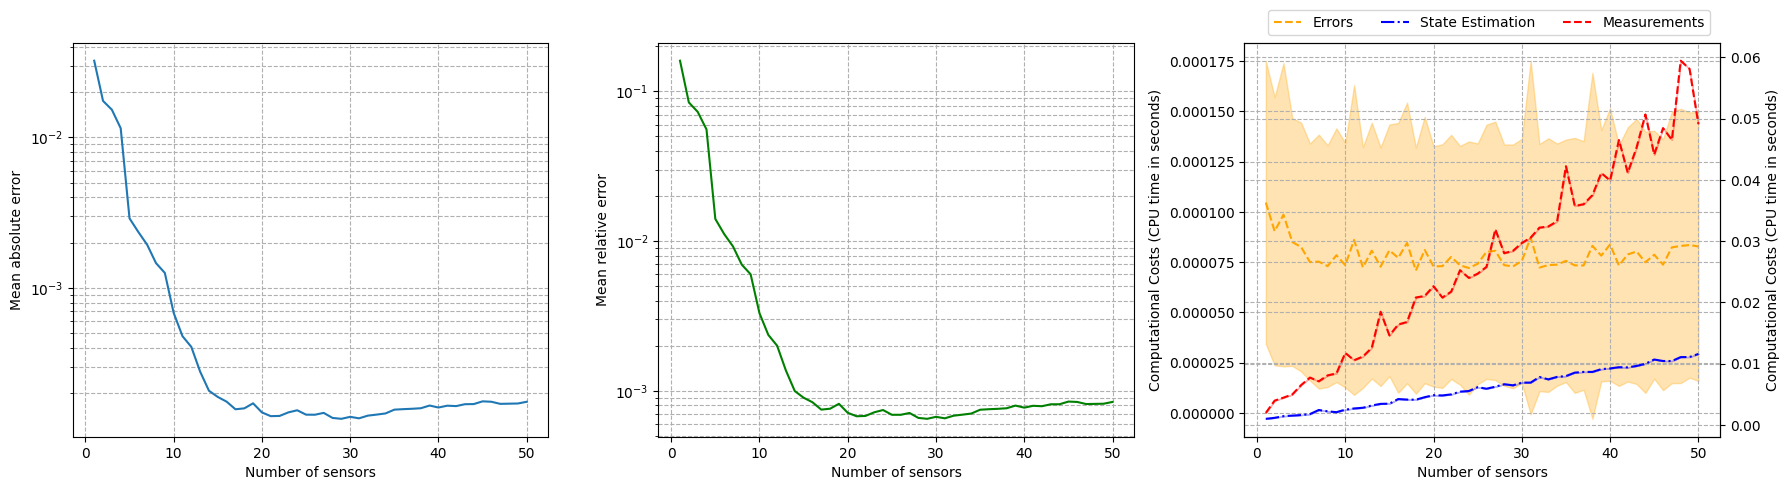

In [31]:
np.random.seed(42)
res_geim_online_noiseless = geim_online.compute_errors(test_dataset, Mmax=50, verbose=True)

Mplot = np.arange(1, len(res_geim_online_noiseless[0]) + 1)

fig, axs = plt.subplots(1, 3, figsize=(6 * 3, 5))

axs[0].semilogy(Mplot, res_geim_online_noiseless[0])
axs[1].semilogy(Mplot, res_geim_online_noiseless[1], color='green')

axs[2].plot(Mplot, res_geim_online_noiseless[2]['Errors'].mean(axis=0), color='orange', linestyle='--', label='Errors')
axs[2].fill_between(Mplot, res_geim_online_noiseless[2]['Errors'].mean(axis=0) - res_geim_online_noiseless[2]['Errors'].std(axis=0),
                    res_geim_online_noiseless[2]['Errors'].mean(axis=0) + res_geim_online_noiseless[2]['Errors'].std(axis=0), color='orange', alpha=0.3)

_ax = axs[2].twinx()
_ax.plot(Mplot, res_geim_online_noiseless[2]['StateEstimation'].mean(axis=0), color='blue', linestyle='-.', label='State Estimation')
_ax.fill_between(Mplot, res_geim_online_noiseless[2]['StateEstimation'].mean(axis=0) - res_geim_online_noiseless[2]['StateEstimation'].std(axis=0),
                 res_geim_online_noiseless[2]['StateEstimation'].mean(axis=0) + res_geim_online_noiseless[2]['StateEstimation'].std(axis=0), color='blue', alpha=0.3)
_ax.plot(Mplot, res_geim_online_noiseless[2]['Measures'].mean(axis=0), color='red', linestyle='--', label='Measurements')
_ax.fill_between(Mplot, res_geim_online_noiseless[2]['Measures'].mean(axis=0) - res_geim_online_noiseless[2]['Measures'].std(axis=0),
                 res_geim_online_noiseless[2]['Measures'].mean(axis=0) + res_geim_online_noiseless[2]['Measures'].std(axis=0), color='red', alpha=0.3)


_line, _label = axs[2].get_legend_handles_labels()
_tmp = _ax.get_legend_handles_labels()
_line += _tmp[0]
_label += _tmp[1]
axs[2].legend(_line, _label, loc=(0.05, 1.02), ncol=3)

for ax in axs:
    ax.set_xlabel('Number of sensors')
    ax.grid(True, which="both", ls="--")
_ax.grid(True, which="both", ls="--")

axs[0].set_ylabel('Mean absolute error')
axs[1].set_ylabel('Mean relative error')
axs[2].set_ylabel('Computational Costs (CPU time in seconds)')
_ax.set_ylabel('Computational Costs (CPU time in seconds)')

plt.tight_layout()

For real-world applications, the measurements are often corrupted by noise $y_m = u(x_m) + \epsilon_m$, where $\epsilon_m$ is a random noise term. The class provides the possibility to add Gaussian noise to the measurements when estimating the fields: we will observe how the relative reconstruction error is affected by different levels of noise.

Computing errors with noise level: 0.0
Computing errors with noise level: 0.001
Computing errors with noise level: 0.01
Computing errors with noise level: 0.025
Computing errors with noise level: 0.05


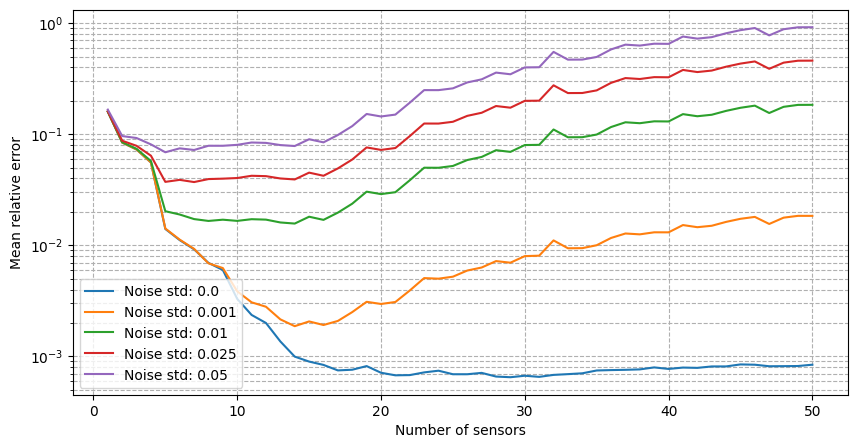

In [32]:
errors_geim_online_sensitivity_noise = {}
noise_values = [0., 0.001, 0.01, 0.025, 0.05]

for noise in noise_values:

    print(f'Computing errors with noise level: {noise}')

    np.random.seed(42)
    res_geim_online = geim_online.compute_errors(test_dataset, Mmax=50, noise_std=noise, verbose=False)
    errors_geim_online_sensitivity_noise[noise] = res_geim_online[1]

fig, axs = plt.subplots(figsize=(10,5))

for noise in noise_values:
    axs.semilogy(Mplot, errors_geim_online_sensitivity_noise[noise], label=f'Noise std: {noise}')

axs.set_xlabel('Number of sensors')
axs.set_ylabel('Mean relative error')
axs.grid(True, which="both", ls="--")
axs.legend()

It can be observed that there is an even stronger degradation of the performance and instability of the reconstruction process is observed. Following the work of [Introini et al. (2023)](https://www.sciencedirect.com/science/article/pii/S0045782522007290), a possible solution is to use Tikhonov regularization to stabilize the solution of the linear system as before.

For uncostrained problems, the regularisation parameters $\lambda$ has an optimal value at $\sigma^2$, where $\sigma^2$ is the variance of the noise. The matrix $\mathbb{T}$ and the mean of the coefficients can be computed using the `set_tikhonov_matrices` method, which requires as input either the training coefficients or the training snapshots (in this case, the training coefficients will be computed internally).

The `compute_errors` method of the class allows to specify the type of regularization and the corresponding parameters through the `regularization_params` dictionary: required entries are the `type` (currently only `tikhonov` is implemented) and the `lambda` parameter.

Computing errors with noise level with regularisation: 0.0


/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/online/geim.py:303: RuntimeWarning: divide by zero encountered in matmul
  rhs = _B.T @ measures[:_m] + lambda_reg * (_T.T @ _T @ _beta_mean[:, np.newaxis])
/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/online/geim.py:303: RuntimeWarning: overflow encountered in matmul
  rhs = _B.T @ measures[:_m] + lambda_reg * (_T.T @ _T @ _beta_mean[:, np.newaxis])
/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/online/geim.py:303: RuntimeWarning: invalid value encountered in matmul
  rhs = _B.T @ measures[:_m] + lambda_reg * (_T.T @ _T @ _beta_mean[:, np.newaxis])
/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/online/geim.py:302: RuntimeWarning: divide by zero encountered in matmul
  A = _B.T @ _B + lambda_reg * (_T.T @ _T)
/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/online/geim.py:302: RuntimeWar

Computing errors with noise level with regularisation: 0.001
Computing errors with noise level with regularisation: 0.01
Computing errors with noise level with regularisation: 0.025
Computing errors with noise level with regularisation: 0.05


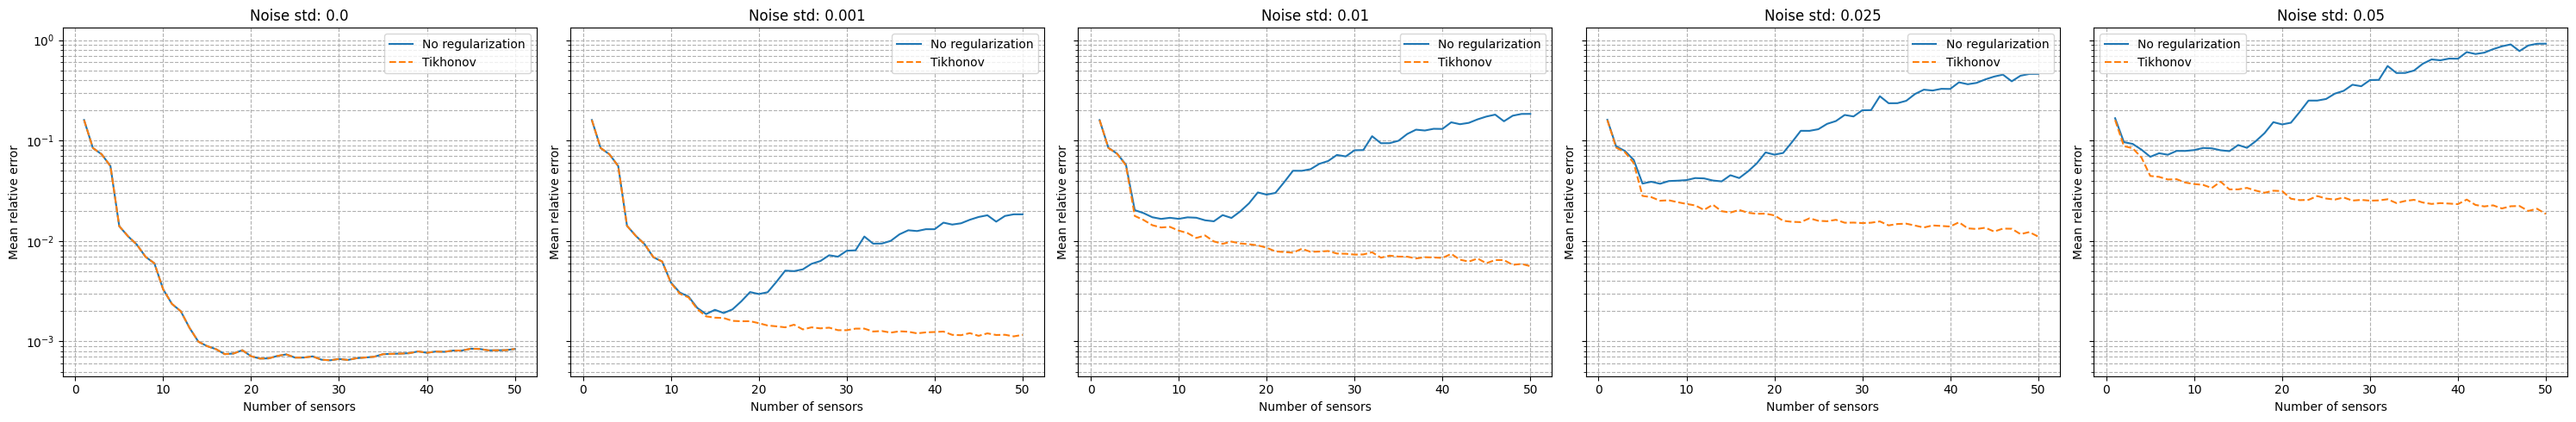

In [33]:
# geim_online.set_tikhonov_matrices(train_beta_geim_coeffs)
geim_online.set_tikhonov_matrices(train_snaps=train_dataset)

errors_geim_online_sensitivity_tikhonov = {}
noise_values = [0., 0.001, 0.01, 0.025, 0.05]

for noise in noise_values:

    print(f'Computing errors with noise level with regularisation: {noise}')

    np.random.seed(42)
    res_geim_online = geim_online.compute_errors(test_dataset, Mmax=50, noise_std=noise, verbose=False, regularization_params={'type': 'tikhonov', 'lambda': noise**2})
    errors_geim_online_sensitivity_tikhonov[noise] = res_geim_online[1]

fig, axs = plt.subplots(1, len(noise_values), figsize=(6* len(noise_values), 5), sharey=True, sharex=True)

for i, noise in enumerate(noise_values):
    axs[i].semilogy(Mplot, errors_geim_online_sensitivity_noise[noise], label=f'No regularization')
    axs[i].semilogy(Mplot, errors_geim_online_sensitivity_tikhonov[noise], linestyle='--', label=f'Tikhonov')
    axs[i].set_title(f'Noise std: {noise}')

for ax in axs.flatten():
    ax.set_xlabel('Number of sensors')
    ax.set_ylabel('Mean relative error')
    ax.grid(True, which="both", ls="--")
    ax.legend()

plt.tight_layout()

/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/online/geim.py:302: RuntimeWarning: divide by zero encountered in matmul
  A = _B.T @ _B + lambda_reg * (_T.T @ _T)
/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/online/geim.py:302: RuntimeWarning: overflow encountered in matmul
  A = _B.T @ _B + lambda_reg * (_T.T @ _T)
/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/online/geim.py:302: RuntimeWarning: invalid value encountered in matmul
  A = _B.T @ _B + lambda_reg * (_T.T @ _T)
/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/online/geim.py:303: RuntimeWarning: divide by zero encountered in matmul
  rhs = _B.T @ measures[:_m] + lambda_reg * (_T.T @ _T @ _beta_mean[:, np.newaxis])
/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/online/geim.py:303: RuntimeWarning: overflow encountered in matmul
  rhs = _B.T @ measures[:_m] + lambda_reg * (

Text(0.5, 1.0, 'Residual with Tikhonov regularization')

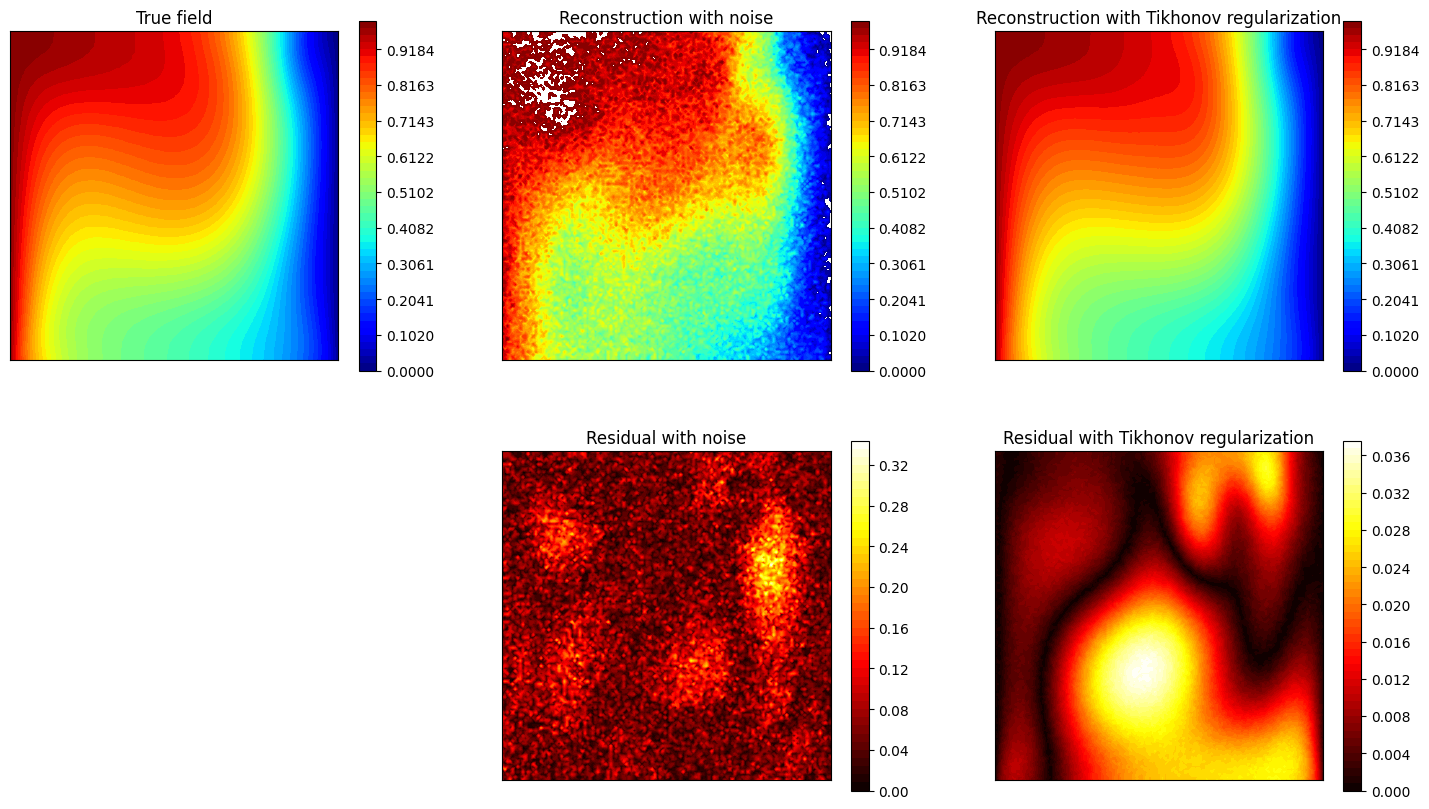

In [35]:
noise_test = 0.02
M_test = 20

measures = geim_online.get_measurements(test_dataset, noise_std=noise_test, M=M_test)
recons_noise = geim_online.estimate(measures)
recons_tikhonov = geim_online.estimate(measures, regularization_params={'type': 'tikhonov', 'lambda': noise_test**2})

nodes = grid.cell_centers().points
levels = np.linspace(0, 1, 50)

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

c = axs[0,0].tricontourf(nodes[:, 0], nodes[:, 1], test_dataset(-1), levels=levels, cmap='jet')
axs[0,1].tricontourf(nodes[:, 0], nodes[:, 1], recons_noise(-1), levels=levels, cmap='jet')
axs[0,2].tricontourf(nodes[:, 0], nodes[:, 1], recons_tikhonov(-1), levels=levels, cmap='jet')

for ax in axs[0,:]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')
    fig.colorbar(c, ax=ax)
    
axs[1,0].axis('off')
c = axs[1,1].tricontourf(nodes[:, 0], nodes[:, 1], np.abs(test_dataset(-1) - recons_noise(-1)), levels=50, cmap='hot')
fig.colorbar(c, ax=axs[1,1])
c = axs[1,2].tricontourf(nodes[:, 0], nodes[:, 1], np.abs(test_dataset(-1) - recons_tikhonov(-1)), levels=50, cmap='hot')
fig.colorbar(c, ax=axs[1,2])

for ax in axs[1,1:]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')

axs[0,0].set_title('True field')
axs[0,1].set_title('Reconstruction with noise')
axs[0,2].set_title('Reconstruction with Tikhonov regularization')
axs[1,1].set_title('Residual with noise')
axs[1,2].set_title('Residual with Tikhonov regularization')